# TPSC and the Mermin-Wagner theorem

## Introduction

The Mermin-Wagner theorem states that a continuous-symmetry cannot be broken at finite temperature in two dimensions. So, antiferromagnetism is impossible in two dimensions, contrary to the prediction of RPA. Here is a heuristic proof. Assume that the spins are collinear in the $z$ direction. Then the free energy density contains a term proportional to $(\nabla S^z)^2/2$. In Fourier space, this becomes $-q^2|S^z(\mathbf{q})|^2/2$. In the long wavelength limit, where fluctuations are slow, we can use the classical equipartition theorem so that 

$$|S^z(\mathbf{q})|^2=\frac{k_BT}{q^2}$$. 

This means that the local moment diverges because of an infrared divergence

$$\left<(S^z)^2\right>\sim \int d^2q |S^z(\mathbf{q})|^2\sim \int d^2q\frac{k_BT}{q^2}=\infty$$. 

We come to an absurdity, which proves that the hypothesis is wrong, there is no long-range order. 

To see that TPSC satisfies the Mermin-Wagner theorem, first note that the spin susceptibility has the following spectrral representation

$$\chi_{sp}(\mathbf{q},i\omega_n)=\int\frac{d\omega}{\pi}\frac{\chi_{sp}''(\mathbf{q},\omega)}{\omega-i\omega_n}=\int\frac{d\omega}{\pi}\frac{\chi_{sp}''(\mathbf{q},\omega)\omega}{\omega^2+(\omega_n)^2}.$$

The last equality follows from the fact $\chi_{sp}''(\mathbf{q},\omega)$ is odd in frequency. This last result shows that the finite Matsubara frequencies should be regular. The largest contribution is the zero-Matsubara frequency one. This allows us to give a rough idea of why the theorem is satisfied by focusing on the zero Matsubara frequency contribution. 

Let us then write the self-consistency condition for $U_{sp}$ as follows :

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q}} \frac{\chi_0(\mathbf{q},0)}{1-\frac{U_{sp}}{2}\chi_0(\mathbf{q},0)}=n-2\left< n_\uparrow n_\downarrow\right>-C(T)
\end{equation}

where $C(T)$ contains the non-singular contribution of the finite Matsubara frequencies. 

Calling the right-hand side $C'(T)$, expanding the denominator around the maximum at $\mathbf{Q}=(\pi,\pi)$ and shifting the origin of the wave vector integration to $\mathbf{Q}=(\pi,\pi)$, the self-consistency condition can be written as  

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q}} \frac{A}{\xi^{-2}+q^2}=C'(T)
\end{equation}
where $A$ is a constant and $\xi$ the correlation length contains the value of $U_{sp}$. Since the right-hand side is finite, $\xi$ adjusts itself not to become infinite, otherwise the left-hand side diverges. The divergence of the susceptibility can occur only at $T=0$ where we cannot treat the non-zero Matsubara frequencies separately. 




## Exercise: Temperature sweep

The goal of the exercise is to compute a temperature sweep for $n=1$ and $U=4$ and examine the validity of the Mermin-Wagner theorem in the TPSC approximation.

We compute the spin structure factor which is given by 
$$S(\mathbf{q})\equiv T\sum_n \chi_{sp}(\mathbf{q},i\omega_n)$$

We want to reproduce the following figure from the
__[paper](https://jp1.journaldephysique.org/articles/jp1/abs/1997/11/jp1v7p1309/jp1v7p1309.html)__ :
<img src="./img/Fig7.png" alt="Drawing" style="width: 250px;"/>


In [1]:
from pytriqs.plot.mpl_interface import plt
import numpy as np
from pytriqs.lattice import BravaisLattice, BrillouinZone
from pytriqs.gf import MeshBrillouinZone, MeshImFreq, Gf, MeshProduct, Idx, inverse
from pytriqs.archive import HDFArchive
from scipy.optimize import fsolve, brentq
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,9) # set default size for all figuresfrom pytriqs.archive import HDFArchivefrom pytriqs.gf import Gf, inverse

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Parameters

Here are suggested discretization parameters for the $n=1$ and $U=4$ temperature sweep.

In [2]:
n = 1.0
U = 4.0
t = 1.0
n_k = 32 # Number of k points per direction
n_w = 128 # Number of Matsubara frequencies

# Two unit vectors in R3
BL = BravaisLattice([(1, 0, 0), (0, 1, 0)])
BZ = BrillouinZone(BL)
kmesh = MeshBrillouinZone(BZ, n_k = n_k)

## Code for the TPSC self consistency

**(from previous notebooks, please just run)**

In [3]:
%reload_ext cpp2py.magic

In [4]:
%%cpp2py -C pytriqs
#include <triqs/gfs.hpp>
using namespace triqs::gfs;

// The type of a Green function : (k,omega) -> Complex number
using g_k_w_type = gf_view<cartesian_product<brillouin_zone, imfreq>, scalar_valued>;
using g_r_t_type = gf<cartesian_product<cyclic_lattice, imtime>, scalar_valued>;

g_k_w_type bubble(g_k_w_type g0) {
    
    // Fourier Transformation of k, \omega to obtain g(r,t)
    auto grt = make_gf_from_fourier<0,1>(g0);
    
    // The mesh of gtr is a cartesian product mt x mr. We decompose it.
    auto [mr, mt] = grt.mesh();
    
    // The inverse temperature from the mesh
    double beta = mt.domain().beta;
    
    // A new mesh for chi, with a bosonic statistics, but same size as mt.
    auto mtb = gf_mesh<imtime>{beta, Boson, mt.size()};
    
    // Build chi (r, tau) with this new mesh.
    auto chi0 = g_r_t_type{{mr, mtb}};

    // we fill chi : chi(tau, r) = 2 * g(beta - tau, -r) * g(tau, r)
    for (auto const &r : mr)      
        for (auto const &t : mtb) 
            chi0[r, t] = 2*grt(-r, beta - t) * grt(r, t); 

    // Fourier transform back to k, \omega space and return
    return make_gf_from_fourier<0,1>(chi0);
}

In [5]:
def eps(kx,ky):
    return -2 * t* (np.cos(kx) + np.cos(ky))

def chi_rpa(chi0, U):
    """Compute chi_rpa from chi"""
    return chi0 * inverse(1 - 0.5 * U * chi0)

def trace_chi(chi):
    """Given chi_kw, it computes sum_k sum_\nu chi(k,\nu)""" 
    kmesh, wmesh = chi.mesh.components
    trace = chi.data.sum() / len(kmesh) / wmesh.beta
    return trace.real

def Usp_root(Usp, chi0, n, U):
    """Sets the self-consistency for U_sp as the problem of finding roots"""
    tr_chi_sp = trace_chi(chi_rpa(chi0, U=Usp))
    diff = tr_chi_sp + 0.5 * Usp/U * n**2 - n
    return diff

def Uch_root(Uch, chi0, n, U, docc):
    tr_chi = trace_chi(chi_rpa(chi0, U=-Uch))
    diff = tr_chi - 2 * docc - n + n**2
    return diff

def solve_tpsc(chi0, U, n):
    Uc = 2/chi0([np.pi,np.pi,0],0).real
    Usp = brentq(Usp_root, 0, Uc, args=(chi0, n, U), xtol=1e-2)
    docc = 0.25 * Usp / U * n**2
    Uch = brentq(Uch_root, 0, 100, args=(chi0, n, U, docc), xtol=1e-2)
    return Usp, Uch, docc, Uc

## Fast $\chi_0$ calculator

Since we have to recompute the Lindhard bubble $\chi_0$ for every temperature we provide a faster implementation of the bubble calculation below.

In [6]:
def get_chi0(beta):
    
    # Init g0
    wmesh = MeshImFreq(beta=beta, S='Fermion', n_max=n_w)
    w = np.tensordot(np.ones(n_k*n_k), list(wmesh.values()), 0)
    k = np.tensordot(list(kmesh.values()), np.ones(2*n_w), 0)
    kx, ky = k[:,0,:], k[:,1,:]

    g0 = Gf(mesh = MeshProduct(kmesh, wmesh), target_shape = [])
    g0.data[:,:] = 1 / (w - eps(kx,ky))
    
    return bubble(g0)

## RPA spin structure factor $S_{RPA}$ as a function of temperature $T$

For comparison we compute the RPA spin structure factor $S_{RPA}$ for a range of temperatures. Note that $T_c^{(RPA)} \approx 0.75$.

In [7]:
T_rpa_vec = np.concatenate((np.arange(4., 3., -1.), np.arange(3, 0.75, -0.2)))
S_rpa_vec = np.zeros_like(T_rpa_vec)

print ''.join('| %-11s' % s for s in ['T', 'beta', 'S_rpa']), '|'
print '-'*41

for idx, T in enumerate(T_rpa_vec):

    beta = 1. / T
    chi0_kw = get_chi0(beta)
    chi = chi_rpa(chi0_kw, U)
    
    S_rpa = chi[Idx(n_k/2, n_k/2, 0), :].data.sum().real 
    S_rpa_vec[idx] = S_rpa
    
    print ''.join('| %4.4E ' % x for x in [T, beta, S_rpa]), '|'

| T          | beta       | S_rpa       |
-----------------------------------------
| 4.0000E+00 | 2.5000E-01 | 1.7191E-01  |
| 3.0000E+00 | 3.3333E-01 | 2.5914E-01  |
| 2.8000E+00 | 3.5714E-01 | 2.8770E-01  |
| 2.6000E+00 | 3.8462E-01 | 3.2286E-01  |
| 2.4000E+00 | 4.1667E-01 | 3.6704E-01  |
| 2.2000E+00 | 4.5455E-01 | 4.2399E-01  |
| 2.0000E+00 | 5.0000E-01 | 4.9973E-01  |
| 1.8000E+00 | 5.5556E-01 | 6.0458E-01  |
| 1.6000E+00 | 6.2500E-01 | 7.5796E-01  |
| 1.4000E+00 | 7.1429E-01 | 1.0012E+00  |
| 1.2000E+00 | 8.3333E-01 | 1.4423E+00  |
| 1.0000E+00 | 1.0000E+00 | 2.5008E+00  |
| 8.0000E-01 | 1.2500E+00 | 9.9295E+00  |


## TPSC spin structure factor $S_{TPSC}$ as a function of temperature

Using the ansatz $U_{sp}\left<n_\uparrow\right> \left<n_\downarrow\right>=U\left<n_\uparrow n_\downarrow\right>$, the spin susceptibility obeys

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},iq_n} \frac{\chi_0(\mathbf{q},iq_n)}{1-\frac{U\left<n_\uparrow n_\downarrow\right>}{2\left<n_\uparrow\right> \left<n_\downarrow\right>}\chi_0(\mathbf{q},iq_n)}=n-2\left< n_\uparrow n_\downarrow\right>
\end{equation}

When the susceptibility increases, $\left<n_\uparrow n_\downarrow\right>$ on the right-hand side decreases, but then the denominator of the spin susceptibility will lead to a decrease in susceptibility.

More rigorously, we can see that dimension is important here. Let us repeat the argument at the beginning of the notebook. The right-hand side of the equation cannot diverge. Also, on the left-hand side, note that the most divergent contribution is the zero Matsubara frequency, as one can see from the spectral representation and $\chi''(\mathbf{q},\omega)=-\chi''(\mathbf{q},-\omega)$

\begin{equation}
\chi(\mathbf{q},iq_n)=\int \frac{d\omega}{\pi}\frac{\chi''(\mathbf{q},\omega)}{\omega-iq_n}=\int \frac{d\omega}{\pi}\frac{\omega\chi''(\mathbf{q},\omega)}{\omega^2+q_n^2}.
\end{equation}

Using these results, the non-singular finite Matsubara frequency terms can be put on the right-hand side of the sum rule and all that is left is 

\begin{equation}
T\int d^2q \frac{a}{\xi^{2}+q^2}\sim C'(T)
\end{equation}

where we have expanded the susceptibility around $(\pi,\pi)$, gone from sum to integral and shifted the origin of integration so that now $\mathbf{q}$ is the deviation from $(\pi,\pi)$. On dimensional grounds, the left-hand side is logarithmic in two dimensions so that the correlation length scales like $\exp(C'(T)/T)$.


## Exercise

Compute the TPSC spin structure factor for a range of temperatures $T \in [0.25, 4]$ and plot $S_{TPSC}$ and $S_{RPA}$ and determine whether the Mermin-Wagner theorem holds.

In [8]:

T_tpsc_vec = np.array([ 4., 3., 
                       2.5, 2.0, 1.5, 1.2, 1.0, 
                       0.8, 0.6, 0.4, 0.35, 0.3, 0.25])

S_tpsc_vec = np.zeros_like(T_tpsc_vec)
U_sp_vec = np.zeros_like(T_tpsc_vec)
docc_vec = np.zeros_like(T_tpsc_vec)
chi_vec = np.zeros_like(T_tpsc_vec)

print ''.join('| %-11s' % s for s in ['T', 'beta', 'Usp', 'Uch', 'docc', 'S_tpsc']), '|'
print '-'*80

for idx, T in enumerate(T_tpsc_vec):

    beta = 1. / T    
    chi0_kw = get_chi0(beta) 
    
    #Usp, Uch, docc = solve_Usp_and_Uch(chi0_kw, U, n, Usp0=Usp, Uch0=Uch)
    Usp, Uch, docc, UcRPA = solve_tpsc(chi0_kw, U, n)
    
    chi_sp_wk = chi_rpa(chi0_kw, Usp)
    S_tpsc = chi_sp_wk[Idx(n_k/2, n_k/2, 0),:].data.sum().real
    chi_tpsc = chi_sp_wk[Idx(n_k/2, n_k/2, 0),Idx(0)].real

    S_tpsc_vec[idx], U_sp_vec[idx], docc_vec[idx], chi_vec[idx] = S_tpsc, Usp, docc, chi_tpsc

    print ''.join('| %4.4E ' % x for x in [T, beta, Usp, Uch, docc, S_tpsc]), '|'


| T          | beta       | Usp        | Uch        | docc       | S_tpsc      |
--------------------------------------------------------------------------------
| 4.0000E+00 | 2.5000E-01 | 3.1155E+00 | 4.9653E+00 | 1.9472E-01 | 1.6103E-01  |
| 3.0000E+00 | 3.3333E-01 | 2.9074E+00 | 5.2905E+00 | 1.8171E-01 | 2.3180E-01  |
| 2.5000E+00 | 4.0000E-01 | 2.7730E+00 | 5.5599E+00 | 1.7331E-01 | 2.9449E-01  |
| 2.0000E+00 | 5.0000E-01 | 2.6163E+00 | 5.9924E+00 | 1.6352E-01 | 3.9826E-01  |
| 1.5000E+00 | 6.6667E-01 | 2.4442E+00 | 6.7880E+00 | 1.5276E-01 | 5.9549E-01  |
| 1.2000E+00 | 8.3333E-01 | 2.3432E+00 | 7.6283E+00 | 1.4645E-01 | 8.2077E-01  |
| 1.0000E+00 | 1.0000E+00 | 2.2835E+00 | 8.4339E+00 | 1.4272E-01 | 1.0725E+00  |
| 8.0000E-01 | 1.2500E+00 | 2.2351E+00 | 9.4520E+00 | 1.3969E-01 | 1.4996E+00  |
| 6.0000E-01 | 1.6667E+00 | 2.2009E+00 | 1.0583E+01 | 1.3756E-01 | 2.3584E+00  |
| 4.0000E-01 | 2.5000E+00 | 2.1724E+00 | 1.1714E+01 | 1.3577E-01 | 4.9189E+00  |
| 3.5000E-01 | 2.8571E+00 | 

## Temperature behaviour

To see the divergencies it is useful to also study the inverse spin structure factor $S^{-1}$. Plot $S^{-1}$ and see at what temperatures the curves intercept $S^{-1}=0$ to determine the critical temperatures $T_c$ of RPA and TPSC.

Q: Plot the double occupancy and explain its behaviour as a function of temperature. What is the $T \rightarrow \infty$ limit of the double occupancy?

A: Thermal excitations win over the interaction $U$ as temperature increases, whence the double occupancy increase as a function of temperature.

At the lowest temperatures, the sudden fall of double occupancy with decreasing $T$ corresponds to a suddent increase in local moment since $\langle S_z^2 \rangle = n - 2\langle n_\uparrow n_\downarrow \rangle$. The local moment should be large at low $T$ where the system has long range anitferromagnetic order. The sudden fall occurs at a temperature that is a remnant of the mean field transition temperature corresponding to $U_{sp}$. For details see https://doi.org/10.1103/PhysRevLett.90.099702.

In the high temperature limit all states of the single site have equal probability which for the double occupancy gives $\langle n_\uparrow n_\downarrow \rangle = 1/4$.

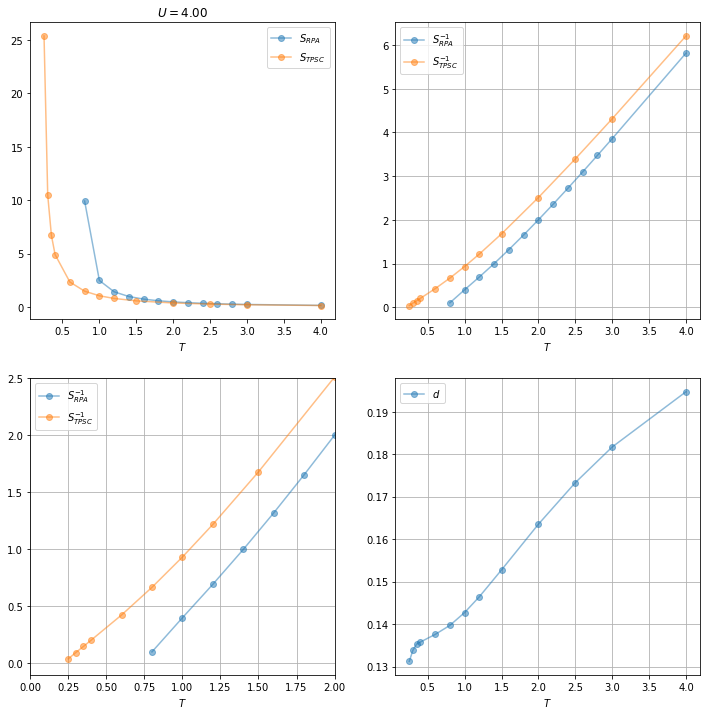

In [9]:
plt.figure(figsize=(12, 12))
# This is to compare with the paper and RPA
plt.subplot(221)
plt.title(r'$U = %2.2f$' % U)
plt.plot(T_rpa_vec, S_rpa_vec, 'o-', label=r'$S_{RPA}$', alpha=0.5)
plt.plot(T_tpsc_vec, S_tpsc_vec, 'o-', label=r'$S_{TPSC}$', alpha=0.5)
plt.legend(loc='best')
plt.xlabel(r'$T$')

# By plotting the inverse of the structure factor, we look for a phase transition. 
plt.subplot(222)
plt.plot(T_rpa_vec, 1./S_rpa_vec, 'o-', alpha=0.5, label=r'$S_{RPA}^{-1}$')
plt.plot(T_tpsc_vec, 1./S_tpsc_vec, 'o-', alpha=0.5, label=r'$S_{TPSC}^{-1}$')
plt.legend(loc='best')
plt.xlabel(r'$T$'); plt.grid()

# This is a blow up of the low temperature result. 
plt.subplot(223)
plt.plot(T_rpa_vec, 1./S_rpa_vec, 'o-', alpha=0.5, label=r'$S_{RPA}^{-1}$')
plt.plot(T_tpsc_vec, 1./S_tpsc_vec, 'o-', alpha=0.5, label=r'$S_{TPSC}^{-1}$')
plt.legend(loc='best'); plt.xlim([0, 2]); plt.ylim([-0.1, 2.5])
plt.xlabel(r'$T$'); plt.grid()

# This shows the behavior of U_sp as a function of temperature.
plt.subplot(224)
plt.plot(T_tpsc_vec, docc_vec, 'o-', alpha=0.5, label=r'$d$')
plt.legend(loc='best')
plt.xlabel(r'$T$')
plt.grid()

## Question
* There seems to be a finite transition temperature even for TPSC. If there is a numerical problem leading to that, can you identify it?

## Answer 

* The zero-Matsubara frequency contribution to the local moment sum-rule is a logarithmically divergent integral when the correlation length is infinite. Since the right-hand side of the sum-rule is finite, the correlation length is forced to remain finite. If the momentum mesh is discrete and does not include $0$, the discrete numerical integral converges even for an infinite correlation length, so there is a finite transition temperature. See the remarks below for how to solve this problem. It amounts to basically doing a careful analysis of the asymptotic behavior, subtracting this asymptotic behavior in the numerical integral and adding the analytical expression for the asymptotic part.   

## Remarks
* To evaluate the integrals and sums entering the sum rules accurately, one must use several tricks that are described in appendix B of this [paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.53.14236).
* The asymptotic behavior of the self-consistency equation is done in a more rigorous way as an intermediate step in this [discussion of the critical behavior](http://iopscience.iop.org/article/10.1209/0295-5075/84/37013/meta).
* $U_{sp}$ vanishing as $T->0$ is unphysical. It is a consequence of the fact that to avoid the phase transition, $U_{sp}$ must be smaller than the mean-field value $$ U_c^{(RPA)} = \frac{2}{\chi_0(\mathbf{k}_{AF}, 0)} $$ which is zero at $T=0$ because the susceptibility diverges there for the perfectly nested Fermi surface.
* The results can be trusted at temperatures not too far below the rapid crossover in the renormalized classical regime where $\xi$ starts to grow exponentially. In particular, the sudden fall of $U_{sp}$ around $T=0.5$ is seen by other methods in this [comment](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.90.099702).
* The internal consistency condition $Tr[\Sigma G]=2U\left< n_\uparrow n_\downarrow \right>$ can be used to estimate the domain of validity of the approach.                                                                  